# Galaxy Tool Sequence Prediction

In [1]:
import os, time, json, sys, logging
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Set project root
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger("lstm_training_optimized")
logger.info(f"Project Root: {PROJECT_ROOT}")

2026-02-16 12:15:01,413 - INFO - Project Root: /home/henok/Desktop/Galaxy-GNN-XP-2


In [2]:
# 1. Hyperparameter Configuration (Optimized for Regularization)
config = {
    "batch_size": 64,       
    "epochs": 50,
    "lr": 1e-3,
    "embed_dim": 256,        
    "hidden_dim": 512,        
    "num_layers": 2,
    "dropout": 0.4,           
    "weight_decay": 5e-4,     
    "label_smoothing": 0.1,  
    "patience": 10,           
    "grad_clip": 1.0,
    "margin": 0.5             
}

In [3]:
# 2. Load Processed Data (Including Negatives)
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"
MODEL_SAVE_DIR = PROJECT_ROOT / "Outputs"
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)

logger.info("Loading datasets...")
import pandas as pd

# Load CSV files and convert to tensors
X_train_df = pd.read_csv(PROCESSED_DATA_DIR / "X_train.csv")
y_train_df = pd.read_csv(PROCESSED_DATA_DIR / "y_train.csv")
train_neg_df = pd.read_csv(PROCESSED_DATA_DIR / "train_negatives.csv")

X_test_df = pd.read_csv(PROCESSED_DATA_DIR / "X_test.csv")
y_test_df = pd.read_csv(PROCESSED_DATA_DIR / "y_test.csv")
test_neg_df = pd.read_csv(PROCESSED_DATA_DIR / "test_negatives.csv")

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_df.values, dtype=torch.long)
y_train = torch.tensor(y_train_df.values.flatten(), dtype=torch.long)
Context_Neg_Train = torch.tensor(train_neg_df.values, dtype=torch.long)

X_test = torch.tensor(X_test_df.values, dtype=torch.long)
y_test = torch.tensor(y_test_df.values.flatten(), dtype=torch.long)
Context_Neg_Test = torch.tensor(test_neg_df.values, dtype=torch.long)

with open(PROCESSED_DATA_DIR / "vocab.json", "r") as f:
    v_dict = json.load(f)
    stoi, itos = v_dict["stoi"], {int(k): v for k, v in v_dict["itos"].items()}

vocab_size, pad_idx = len(stoi), stoi.get("<PAD>", 0)
logger.info(f"Vocab Size: {vocab_size} | Training Samples: {len(X_train)} | Test Samples: {len(X_test)}")

2026-02-16 12:15:46,916 - INFO - Loading datasets...
2026-02-16 12:15:48,226 - INFO - Vocab Size: 1519 | Training Samples: 5992 | Test Samples: 901


In [4]:
# 3. Model Architecture (Last Hidden State Refinement)
class GalaxyPredictorRefined(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512, num_layers=2, dropout=0.4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0, 
                            bidirectional=False)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x):
        # x: (batch, seq)
        embedded = self.embedding(x)
        
        # LSTM
        out, (hn, cn) = self.lstm(embedded)
        
        # Use only the last hidden state of the top layer
        last_hidden = hn[-1] # (batch, hidden)
        
        final_repr = self.drop(last_hidden)
        logits = self.fc(final_repr)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GalaxyPredictorRefined(
    vocab_size, 
    embed_dim=config["embed_dim"], 
    hidden_dim=config["hidden_dim"], 
    num_layers=config["num_layers"], 
    dropout=config["dropout"]
).to(device)
logger.info(f"Model (Refined) initialized on device: {device}")
logger.info(f"Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


2026-02-16 12:15:55,453 - INFO - Model (Refined) initialized on device: cpu
2026-02-16 12:15:55,455 - INFO - Model Parameters: 4846319


In [5]:
# 4. Enhanced Training Loop with Contrastive Ranking Loss & Top-K Monitor

# Helper for Top-K
def calculate_topk_accuracy(logits, targets, k=5):
    _, indices = torch.topk(logits, k, dim=1)
    correct = indices.eq(targets.unsqueeze(1).expand_as(indices))
    return correct.sum().item()


train_loader = DataLoader(TensorDataset(X_train, y_train, Context_Neg_Train), 
                          batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(TensorDataset(X_test, y_test, Context_Neg_Test), 
                        batch_size=config["batch_size"], shuffle=False)

# Losses
classification_criterion = nn.CrossEntropyLoss(ignore_index=pad_idx, label_smoothing=config["label_smoothing"])
ranking_criterion = nn.MarginRankingLoss(margin=config["margin"])

optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

best_val_loss = float('inf')
patience_counter = 0
train_hist, val_hist = [], []
val_hit1_hist, val_hit5_hist = [], []
timestamp = time.strftime("%Y%m%d_%H%M%S")
best_model_path = MODEL_SAVE_DIR / f"best_galaxy_lstm_opt_{timestamp}.pth"

logger.info("Starting optimized training loop...")
for epoch in range(config["epochs"]):
    # --- Training Phase ---
    model.train()
    epoch_train_loss = 0
    
    for bx, by, bneg in train_loader:
        bx, by, bneg = bx.to(device), by.to(device), bneg.to(device)
        optimizer.zero_grad()
        
        logits = model(bx)
        
        # 1. Classification Loss
        ce_loss = classification_criterion(logits, by)
        
        # 2. Contrastive Ranking Loss
        # Ideally, Ranking Loss compares Score(Positive) vs Score(Negative)
        
        # Score for Positive Target
        pos_scores = logits.gather(1, by.unsqueeze(1)).squeeze(1)
        
        # Score for Negative Target (using the first negative if multiple)
        # Average Ranking Loss over all negatives
        rank_loss = 0
        for i in range(bneg.size(1)):
            neg_target = bneg[:, i]
            neg_scores = logits.gather(1, neg_target.unsqueeze(1)).squeeze(1)
            rank_loss += ranking_criterion(pos_scores, neg_scores, torch.ones_like(pos_scores))
        rank_loss /= bneg.size(1)
        
        # Target for MarginRankingLoss is 1 (pos > neg)
        
        # Combined Loss
        total_loss = ce_loss + rank_loss
        
        total_loss.backward()
        if config["grad_clip"] > 0:
            nn.utils.clip_grad_norm_(model.parameters(), config["grad_clip"])
        optimizer.step()
        epoch_train_loss += total_loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    
    # --- Validation Phase ---
    model.eval()
    epoch_val_loss = 0
    total_hits_1 = 0
    total_hits_5 = 0
    total_samples = 0
    
    with torch.no_grad():
        for bx, by, bneg in val_loader:
            bx, by, bneg = bx.to(device), by.to(device), bneg.to(device)
            logits = model(bx)
            
            # Losses
            ce_loss = classification_criterion(logits, by)
            
            pos_scores = logits.gather(1, by.unsqueeze(1)).squeeze(1)
            # Average Ranking Loss over all negatives
            rank_loss = 0
            for i in range(bneg.size(1)):
                neg_target = bneg[:, i]
                neg_scores = logits.gather(1, neg_target.unsqueeze(1)).squeeze(1)
                rank_loss += ranking_criterion(pos_scores, neg_scores, torch.ones_like(pos_scores))
            rank_loss /= bneg.size(1)
            
            epoch_val_loss += (ce_loss + rank_loss).item()
            
            # Metrics
            total_hits_1 += calculate_topk_accuracy(logits, by, k=1)
            total_hits_5 += calculate_topk_accuracy(logits, by, k=5)
            total_samples += by.size(0)
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    hit1 = total_hits_1 / total_samples
    hit5 = total_hits_5 / total_samples
    
    train_hist.append(avg_train_loss)
    val_hist.append(avg_val_loss)
    val_hit1_hist.append(hit1)
    val_hit5_hist.append(hit5)
    
    # Scheduler update
    scheduler.step(avg_val_loss)
    
    curr_lr = optimizer.param_groups[0]['lr']
    logger.info(f"Epoch {epoch+1:02d} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | Hit@1: {hit1:.3f} | Hit@5: {hit5:.3f} | LR: {curr_lr:.6f}")
    
    # --- Early Stopping & Checkpointing ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
        logger.info(f"  --> Best model saved with val_loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= config["patience"]:
            logger.warning(f"Early stopping triggered at epoch {epoch+1}")
            break

logger.info(f"Training complete. Best val_loss: {best_val_loss:.4f}")
logger.info(f"Final model saved to {best_model_path.name}")

2026-02-16 12:16:26,288 - INFO - Starting optimized training loop...
2026-02-16 12:16:43,792 - INFO - Epoch 01 | Train: 6.6300 | Val: 6.3394 | Hit@1: 0.088 | Hit@5: 0.194 | LR: 0.001000
2026-02-16 12:16:44,013 - INFO -   --> Best model saved with val_loss: 6.3394
2026-02-16 12:17:02,405 - INFO - Epoch 02 | Train: 5.3165 | Val: 5.8304 | Hit@1: 0.127 | Hit@5: 0.290 | LR: 0.001000
2026-02-16 12:17:02,676 - INFO -   --> Best model saved with val_loss: 5.8304
2026-02-16 12:17:21,132 - INFO - Epoch 03 | Train: 4.4655 | Val: 5.4618 | Hit@1: 0.151 | Hit@5: 0.357 | LR: 0.001000
2026-02-16 12:17:21,465 - INFO -   --> Best model saved with val_loss: 5.4618
2026-02-16 12:17:38,566 - INFO - Epoch 04 | Train: 3.8772 | Val: 5.2160 | Hit@1: 0.184 | Hit@5: 0.393 | LR: 0.001000
2026-02-16 12:17:38,822 - INFO -   --> Best model saved with val_loss: 5.2160
2026-02-16 12:17:55,071 - INFO - Epoch 05 | Train: 3.4077 | Val: 5.1059 | Hit@1: 0.181 | Hit@5: 0.413 | LR: 0.001000
2026-02-16 12:17:55,352 - INFO -  

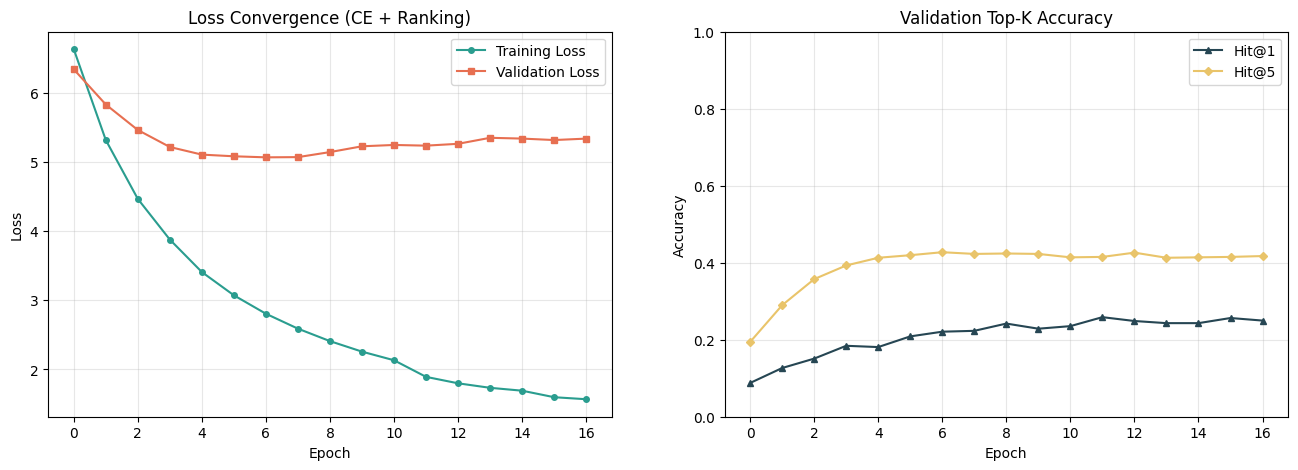

In [14]:
# 5. Training Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Loss Plot
ax1.plot(train_hist, label='Training Loss', color='#2A9D8F', marker='o', markersize=4)
ax1.plot(val_hist, label='Validation Loss', color='#E76F51', marker='s', markersize=4)
ax1.set_title('Loss Convergence (CE + Ranking)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Metrics Plot
ax2.plot(val_hit1_hist, label='Hit@1', color='#264653', marker='^', markersize=4)
ax2.plot(val_hit5_hist, label='Hit@5', color='#E9C46A', marker='D', markersize=4)
ax2.set_title('Validation Top-K Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1.0)
ax2.legend()
ax2.grid(alpha=0.3)


plt.savefig(PROJECT_ROOT / "Outputs" / "optimized_training_convergence.png")
plt.savefig(PROJECT_ROOT / "reports" / f"traing vs validation_loss_after_HR_tunning_{timestamp}.png")

plt.show()